# DQN vs Random Assignment

This notebook compares online actor critic learning with Bernoulli random assignment for contextual bandits.

In [1]:
import numpy as np
import pandas as pd
import torch
from plotnine import *
from demo.contextual_bandit_dgp import Simple
from demo.reinforcement_learning.dqn import DQN

## 1. Initialize the DGP and DQN

Create a Simple contextual bandit DGP and initialize the actor critic model.

In [2]:
# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Initialize the DGP
n_arms = 3
n_features = 5
shared_weight = 0.3

dgp = Simple(n_arms=n_arms, n_features=n_features, shared_weight=shared_weight)

# Initialize the actor-critic model
dqn = DQN(n_features=n_features, n_actions=n_arms, lr=1e-2)

print(f"DGP Beta coefficients shape: {dgp.beta.shape}")
print(f"DQN model: {dqn}")

DGP Beta coefficients shape: (3, 6)
DQN model: DQN(
  (affine1): Linear(in_features=5, out_features=128, bias=True)
  (q_value_head): Linear(in_features=128, out_features=3, bias=True)
)


## 2. Run Online Learning Simulation

Simulate online learning with both:
- **Actor-Critic**: Learns to select better arms over time
- **Random Assignment**: Baseline with uniform random arm selection

In [3]:
# Simulation parameters
n_rounds = 100
batch_size = 32

# Storage for results
dqn_rewards = []
dqn_regrets = []
random_rewards = []
random_regrets = []
dqn_optimal_rates = []
random_optimal_rates = []

for round_idx in range(n_rounds):
    # Generate batch of contexts
    contexts = dgp.x(batch_size)

    # Get optimal arms and rewards for this batch
    optimal_arms = dgp.a_star(contexts)
    optimal_rewards = dgp.r_star(contexts)

    # --- DQN ---
    dqn_actions= dqn.select_actions(contexts)
    dqn_observed = dgp.r(dqn_actions, contexts)

    # Update dqn
    dqn.finish_batch(rewards=dqn_observed, actions=dqn_actions, states=contexts)

    # Record dqn results
    dqn_rewards.extend(dqn_observed)
    dqn_regrets.extend(optimal_rewards - dqn_observed)
    dqn_optimal_rates.append((dqn_actions == optimal_arms).mean())

    # --- Random Assignment ---
    random_actions = np.random.randint(0, n_arms, size=batch_size)
    random_observed = dgp.r(random_actions, contexts)

    # Record random results
    random_rewards.extend(random_observed)
    random_regrets.extend(optimal_rewards - random_observed)
    random_optimal_rates.append((random_actions == optimal_arms).mean())

# Convert to arrays
dqn_rewards = np.array(dqn_rewards)
dqn_regrets = np.array(dqn_regrets)
random_rewards = np.array(random_rewards)
random_regrets = np.array(random_regrets)

n_samples = len(dqn_rewards)
print(f"Simulation complete: {n_rounds} rounds, {n_samples} total samples")

Simulation complete: 100 rounds, 3200 total samples


## 3. Compare Performance Metrics

In [4]:
# Calculate cumulative regrets
dqn_cumulative_regret = np.cumsum(dqn_regrets)
random_cumulative_regret = np.cumsum(random_regrets)

print("=" * 60)
print("PERFORMANCE COMPARISON")
print("=" * 60)

print(f"\n DQN:")
print(f"  Mean reward: {dqn_rewards.mean():.4f}")
print(f"  Mean regret: {dqn_regrets.mean():.4f}")
print(f"  Total cumulative regret: {dqn_cumulative_regret[-1]:.4f}")
print(f"  Final optimal arm rate: {dqn_optimal_rates[-1]*100:.2f}%")

print(f"\nRandom Assignment:")
print(f"  Mean reward: {random_rewards.mean():.4f}")
print(f"  Mean regret: {random_regrets.mean():.4f}")
print(f"  Total cumulative regret: {random_cumulative_regret[-1]:.4f}")
print(f"  Mean optimal arm rate: {np.mean(random_optimal_rates)*100:.2f}%")

print(f"\nImprovement:")
print(f"  Regret reduction: {(1 - dqn_cumulative_regret[-1]/random_cumulative_regret[-1])*100:.2f}%")
print("=" * 60)

PERFORMANCE COMPARISON

 DQN:
  Mean reward: 1.7442
  Mean regret: 0.2054
  Total cumulative regret: 657.3592
  Final optimal arm rate: 100.00%

Random Assignment:
  Mean reward: 0.3717
  Mean regret: 1.5779
  Total cumulative regret: 5049.4227
  Mean optimal arm rate: 33.59%

Improvement:
  Regret reduction: 86.98%


## 4. Visualize Results

In [5]:
# Create dataframes for plotting
df_cumulative = pd.DataFrame({
    'sample': list(range(n_samples)) * 2,
    'cumulative_regret': np.concatenate([dqn_cumulative_regret, random_cumulative_regret]),
    'method': ['DQN'] * n_samples + ['Random'] * n_samples
})

df_regret = pd.DataFrame({
    'regret': np.concatenate([dqn_regrets, random_regrets]),
    'method': ['DQN'] * n_samples + ['Random'] * n_samples
})

df_optimal_rate = pd.DataFrame({
    'round': list(range(n_rounds)) * 2,
    'optimal_rate': dqn_optimal_rates + random_optimal_rates,
    'method': ['DQN'] * n_rounds + ['Random'] * n_rounds
})

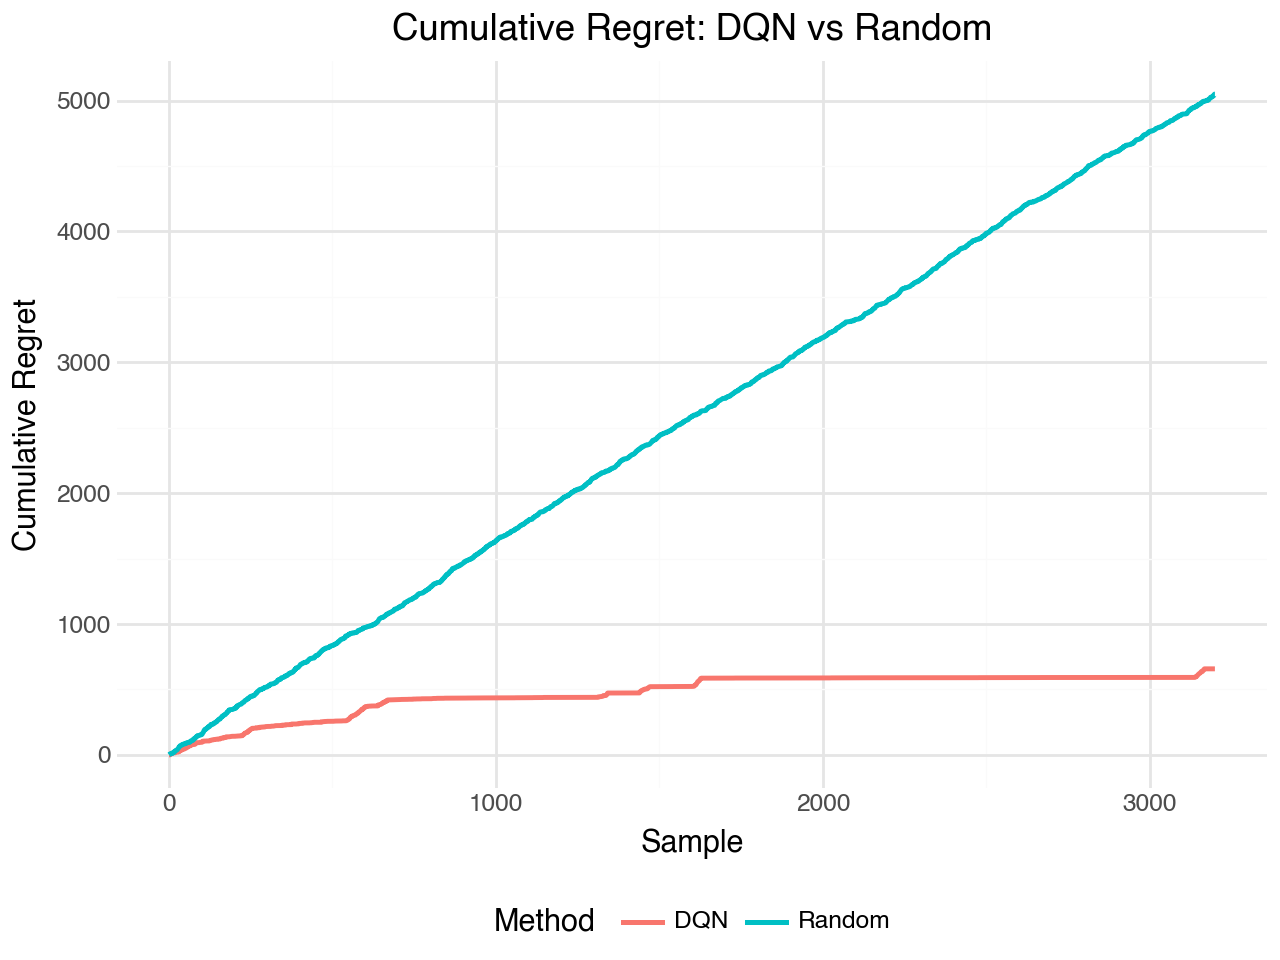

In [6]:
# Plot 1: Cumulative Regret Comparison
p1 = (ggplot(df_cumulative, aes(x='sample', y='cumulative_regret', color='method')) +
      geom_line(size=1) +
      labs(title='Cumulative Regret: DQN vs Random',
           x='Sample',
           y='Cumulative Regret',
           color='Method') +
      theme_minimal() +
      theme(legend_position='bottom'))

p1

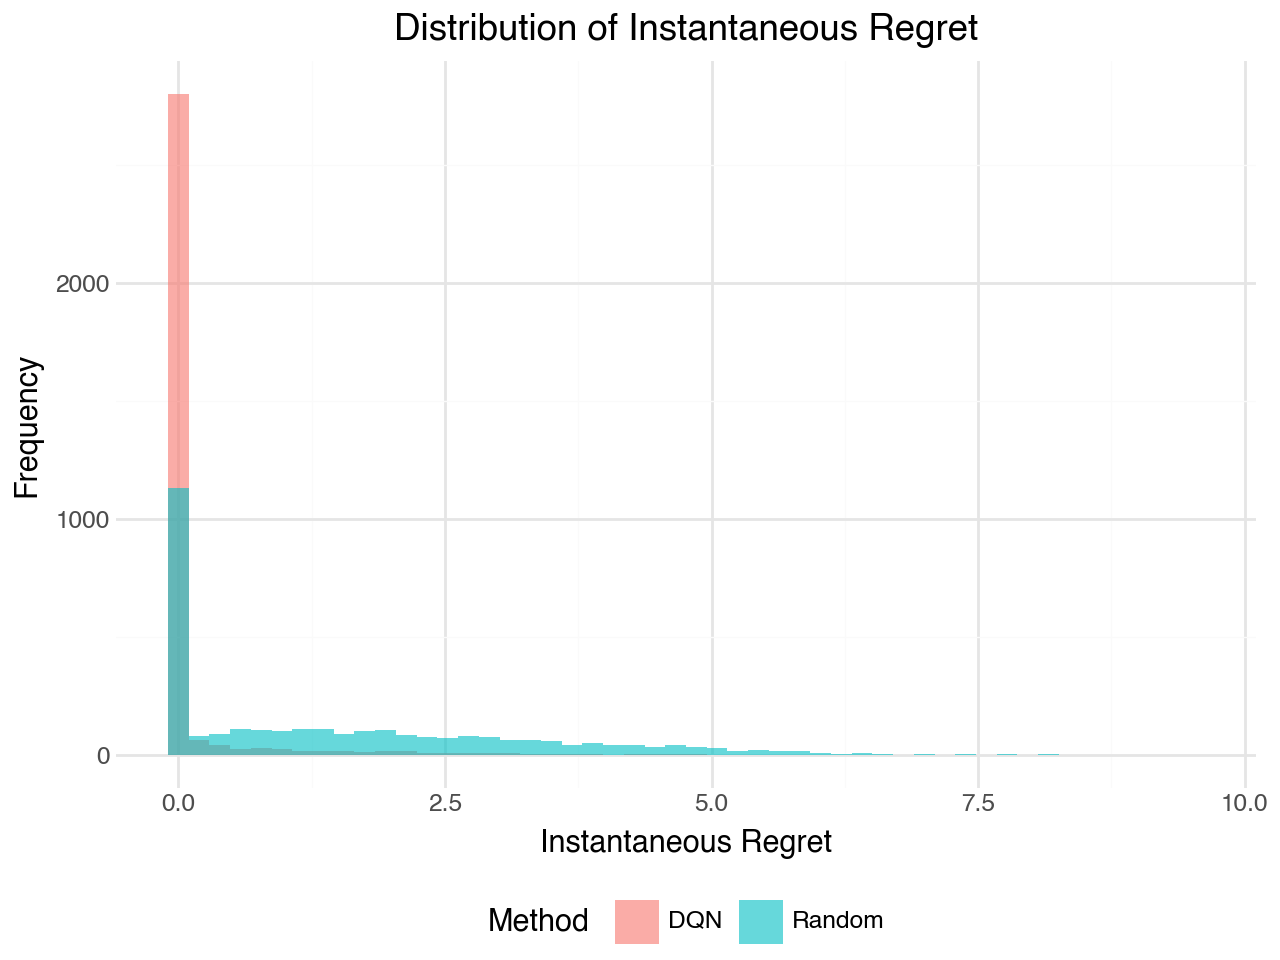

In [7]:
# Plot 2: Instantaneous Regret Distribution
p2 = (ggplot(df_regret, aes(x='regret', fill='method')) +
      geom_histogram(bins=50, alpha=0.6, position='identity') +
      labs(title='Distribution of Instantaneous Regret',
           x='Instantaneous Regret',
           y='Frequency',
           fill='Method') +
      theme_minimal() +
      theme(legend_position='bottom'))

p2

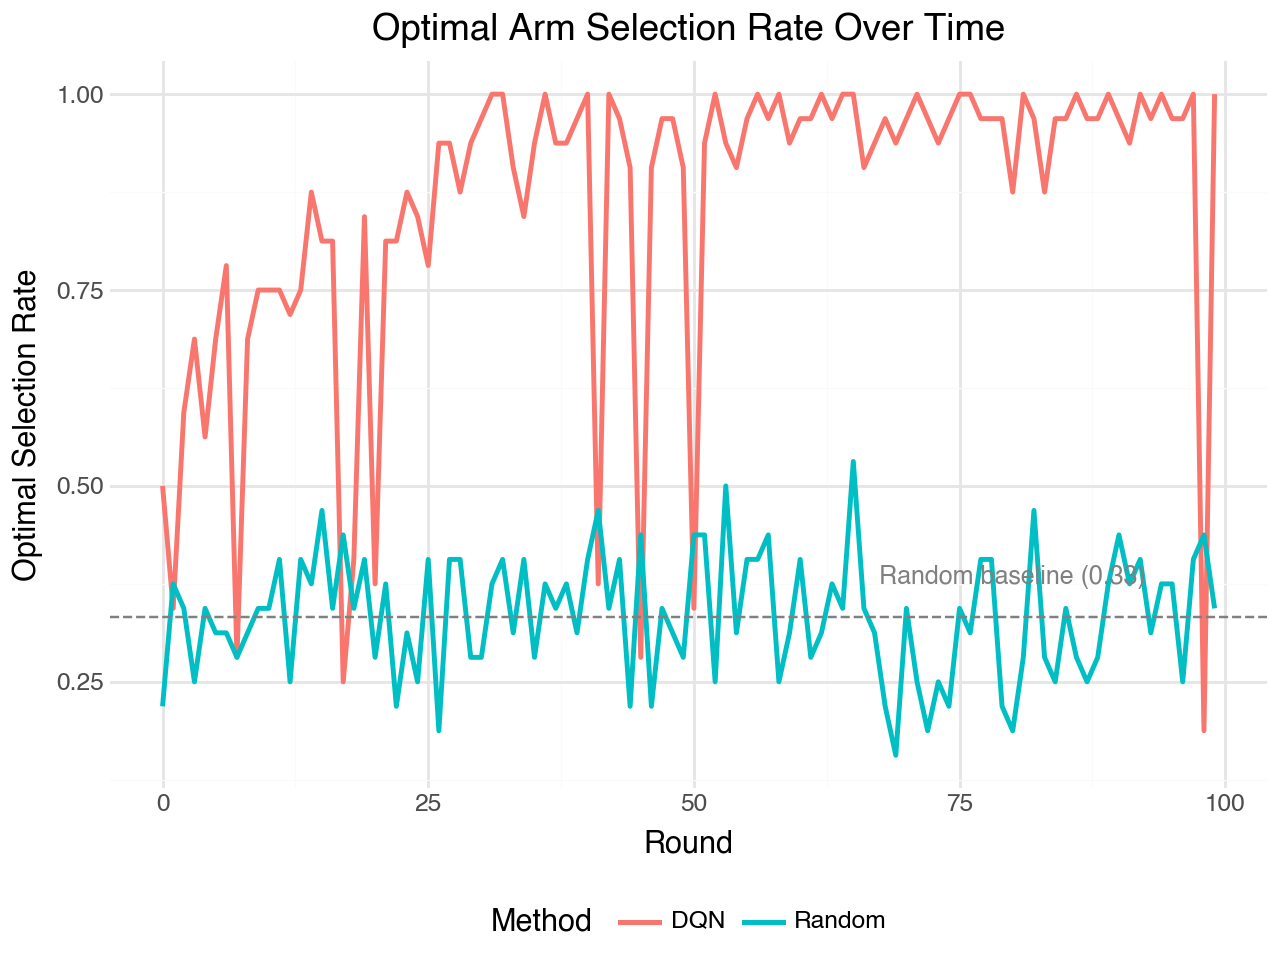

In [8]:
# Plot 3: Optimal Arm Selection Rate Over Time
p3 = (ggplot(df_optimal_rate, aes(x='round', y='optimal_rate', color='method')) +
      geom_line(size=1) +
      geom_hline(yintercept=1/n_arms, linetype='dashed', color='gray') +
      annotate('text', x=n_rounds*0.8, y=1/n_arms + 0.05,
               label=f'Random baseline ({1/n_arms:.2f})', color='gray', size=9) +
      labs(title='Optimal Arm Selection Rate Over Time',
           x='Round',
           y='Optimal Selection Rate',
           color='Method') +
      theme_minimal() +
      theme(legend_position='bottom'))

p3